In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from annette.db import SessionManager
from annette.db.models import Citation, ManualClassification
import dill
import matplotlib.pyplot as plt

Create a generic function to get a list of `{'attribute_name': attribute, 'class': classification}` records:

In [2]:
def get_data(attr_name):
    attr = getattr(Citation, attr_name)

    with SessionManager() as session_manager:
        citations = session_manager.session.query(attr,
                                                  ManualClassification.classification_id) \
            .join(ManualClassification, Citation.doi == ManualClassification.doi) \
            .group_by(attr, ManualClassification.classification_id).all()

    return [{
        attr_name: getattr(c, attr_name) if getattr(c, attr_name) is not None else '',
        'class': c.classification_id
        } for c in citations]

Set up two tokenisers for the `subject` attribute:

In [3]:
from nltk import RegexpParser
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer


def tokenise_subjects_simple(subject):
    if subject == '' or subject is None:
        return []
    return list(set([s.strip().lower() for s in subject.split(',')]))


def tokenise_subjects_phrases(subject):
    if subject == '' or subject is None:
        return []
    split_subjects = []
    phrase_pattern = 'CHUNK:{<JJ>*<NN.?>*<VBG>*}'
    phrase_chunker = RegexpParser(phrase_pattern)
    for s in subject.split(','):
        tokens = word_tokenize(s.strip().lower())
        tags = pos_tag(tokens)
        phrases = [' '.join([leaf[0] for leaf in c.leaves()]) for c in phrase_chunker.parse(tags) if hasattr(c, 'label') and c.label() == 'CHUNK']
        for phrase in phrases:
            phrase_tokens = word_tokenize(phrase)
            phrase_tags = pos_tag(phrase_tokens)
            lemmatised_phrase = []
            for pto, pta in phrase_tags:
                wn_tag = {
                    'n': wn.NOUN,
                    'j': wn.ADJ,
                    'v': wn.VERB,
                    'r': wn.ADV
                    }.get(pta[0].lower(), None)
                if wn_tag is None:
                    continue
                lemmatised = WordNetLemmatizer().lemmatize(pto, wn_tag)
                lemmatised_phrase.append(lemmatised)
            if len(lemmatised_phrase) > 0:
                lemmatised_phrase = ' '.join(lemmatised_phrase)
                split_subjects.append(lemmatised_phrase)
    return list(set(split_subjects))

The simple tokeniser just splits the string by commas (and converts to lowercase). The tags should be fairly standardised, so this shouldn't be too much of a problem.

Just to see if it's more accurate/helpful to process the tags in a different way, we've also defined the 'phrase' tokeniser, which goes through several steps:
1. Split the whole string by commas (assumes the field is a comma-separated list of phrasal tags);
2. Tokenise the phrasal subject tags and identify parts of speech;
3. Extract sub-phrases based on those parts of speech (i.e. adjective-noun-verb combinations, ignoring conjunctives like *and*);
4. Lemmatise the words in those phrases to reduce differences between related tags (e.g. science and sciences both become *science*);
5. Join the words back together to form a lemmatised sub-phrase.

The two tokenisers will generate different length lists from the same input string.

In [4]:
print(tokenise_subjects_simple('Ecology,Aquatic Science,Nature and Landscape Conservation'))
print(tokenise_subjects_phrases('Ecology,Aquatic Science,Nature and Landscape Conservation'))

print(tokenise_subjects_simple('Ecology,Ecology, Evolution, Behavior and Systematics,Nature and Landscape Conservation'))
print(tokenise_subjects_phrases('Ecology,Ecology, Evolution, Behavior and Systematics,Nature and Landscape Conservation'))

['nature and landscape conservation', 'aquatic science', 'ecology']
['aquatic science', 'ecology', 'nature', 'landscape conservation']
['nature and landscape conservation', 'evolution', 'ecology', 'behavior and systematics']
['systematics', 'landscape conservation', 'behavior', 'ecology', 'nature', 'evolution']


Get the list of records for training + testing:

In [5]:
import pandas as pd

records = get_data('subject')
records_df = pd.DataFrame(records)

Both tokenisation processes will otherwise follow the same transformation pipeline in order to extract the train/test data, so we can define a method that takes the tokeniser as an argument to avoid repeating ourselves:

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


def transform_data(tokeniser):
    # a list of all possible tags
    all_items = list(set([item for r in records for item in tokeniser(r['subject'])]))
    print(len(all_items))
    
    # define a binariser and fit it to the list of tags
    binariser = MultiLabelBinarizer()
    binariser.fit([all_items])
    
    # transform all the subject tag data
    all_x = binariser.transform([tokeniser(s) for s in records_df['subject']])
    print(records_df['subject'].to_numpy()[1])
    print(all_x[1])
    
    return all_x, records_df['class']

We need a list of all the possible tags so that we can binarise them (convert them to a numeric representation).

In [7]:
data_simple, labels_simple = transform_data(tokenise_subjects_simple)

103
Ecology,Aquatic Science,Nature and Landscape Conservation
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
data_phrases, labels_phrases = transform_data(tokenise_subjects_phrases)

125
Ecology,Aquatic Science,Nature and Landscape Conservation
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Now we can create the KMeans cluster models. Again, they'll follow the same pipeline, so it's easier to define a generic method that takes the train/test data as an argument.

Since this is *unsupervised* learning, it cannot be scored for accuracy until it's combined with the *supervised* methods. We may need to generate several models with different settings (e.g. for `n_clusters`) to fine-tune the model at a later point.

In [9]:
from sklearn.cluster import KMeans


def create_model(train, n_clusters=2):
    model = KMeans(n_clusters=n_clusters)
    model.fit(train)
    return model

In [10]:
model_simple = create_model(data_simple)
model_phrases = create_model(data_phrases)

Then the model can be saved for later use.

In [11]:
filename = f'kmeans_model_subject.pk'
with open(filename, 'wb') as f:
    dill.dump(model_simple, f)
    

# then to load again:
with open(filename, 'rb') as f:
    loaded_model = dill.load(f)

## Using

The KMeans models are used to give a numerical representation to the list of tags. This can then be included in the training data (along with other features) for supervised learning techniques, e.g. Random Forest classifiers, Naive Bayes, and/or Neural Nets.

The function below demonstrates how it might be used with a Random Forest classifier (without any other features, to keep things simple). It also tests the effect of different `n_clusters` values, and compares the tokenisation methods.

In [20]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np


def random_forest(data, labels):
    forest = RandomForestClassifier(n_estimators=100)
    
    scores = []
    scores_std = []
    for n in range(2, 8):
        model = create_model(data, n_clusters=n)
        predicted = model.predict(data).reshape(-1, 1)
        x_train, x_test, y_train, y_test = train_test_split(predicted, labels,
                                                            test_size=0.2,
                                                            random_state=123, stratify=labels)
        
        # the fit isn't consistent so take the best of 10
        n_scores = []
        for i in range(9):
            forest.fit(x_train, y_train)
            n_scores.append(forest.score(x_test, y_test))
        scores.append(np.max(n_scores))
        scores_std.append(np.max(n_scores) - np.min(n_scores))

    return scores, scores_std

The results do not appear to be very consistent (these graphs should all be the same):

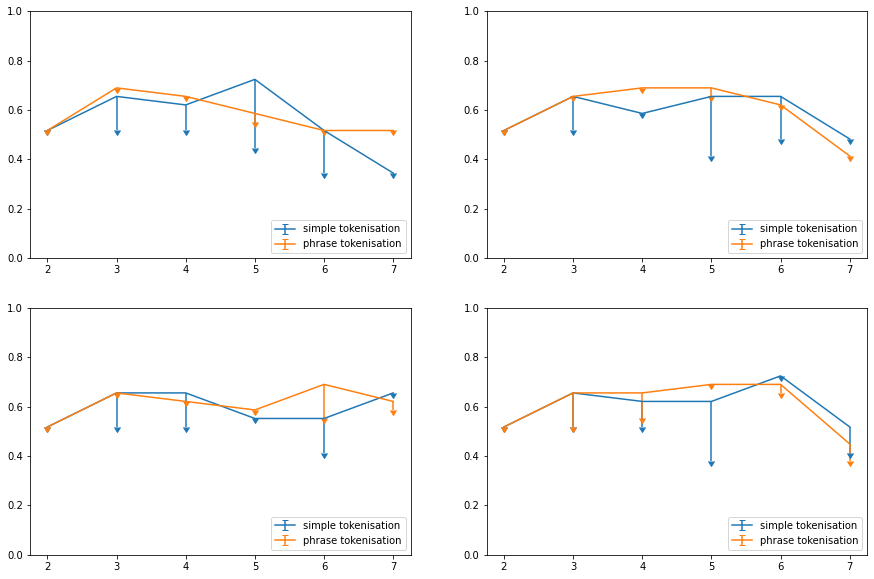

In [24]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
for ax in axes.ravel():
    scores_simple, scores_std_simple = random_forest(data_simple, labels_simple)
    scores_phrases, scores_std_phrases = random_forest(data_phrases, labels_phrases)
    ax.errorbar(range(2,8), scores_simple, scores_std_simple,uplims=True, label='simple tokenisation')
    ax.errorbar(range(2,8), scores_phrases, scores_std_phrases, uplims=True, label='phrase tokenisation')
    ax.set_ylim([0.0, 1.0])
    ax.legend(loc='lower right')
fig.show()